In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv


In [2]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
sales_train = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
sample_sub = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")


In [3]:
def memory_reduction(dataset):
    column_types = dataset.dtypes
    temp = None
    for x in range(len(column_types)):
        column_types[x] = str(column_types[x])
    for x in range(len(column_types)):
        temp = dataset.columns[x]
        if dataset.columns[x] == "date":
            dataset[temp] = dataset[temp].astype("datetime64")
        if column_types[x] == "int64" and dataset.columns[x] != "date":
            dataset[temp] = dataset[temp].astype("int16")
        if column_types[x] == "object" and dataset.columns[x] != "date":
            dataset[temp] = dataset[temp].astype("category")
        if column_types[x] == "float64" and dataset.columns[x] != "date":
            dataset[temp] = dataset[temp].astype("float16")
    return dataset

In [4]:
calendar_df = memory_reduction(calendar)

In [5]:
sell_prices["id"] = sell_prices["item_id"] + "_" + sell_prices["store_id"] + "_validation" 
sell_prices = pd.merge(sell_prices, sales_train[["cat_id", "id", "state_id"]], on = "id")
sell_prices_df = memory_reduction(sell_prices)

In [6]:
sales_train_df = memory_reduction(sales_train)

In [7]:
calendar_df = calendar_df[:1913]
calendar_df["day"] = pd.DatetimeIndex(calendar_df["date"]).day
calendar_df["day"] = calendar_df["day"].astype("int8")
calendar_df["week_num"] = (calendar_df["day"] - 1) // 7 + 1
calendar_df["week_num"] = calendar_df["week_num"].astype("int8")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [8]:
import gc

In [9]:
def make_dataframe():
    # Wide format dataset 
    df_wide_train = sales_train_df.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T
    df_wide_train.index = calendar_df["date"]
    df_wide_train.columns = sales_train_df["id"]
    
   
    # Convert wide format to long format
    df_long = df_wide_train.stack().reset_index(1)
    df_long.columns = ["id", "value"]

    del df_wide_train
    gc.collect()
    
    df = pd.merge(pd.merge(df_long.reset_index(), calendar_df, on="date"), sell_prices_df, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
    #df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")   
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")


    del df_long
    gc.collect()

    return df

df = make_dataframe()

In [10]:
del calendar, sales_train, sell_prices
gc.collect()

20

# EDA STARTS

In [11]:
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_CA,snap_TX,snap_WI,day,week_num,store_id,item_id,sell_price,cat_id,state_id
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,NaN,NaN,...,0,0,0,29,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,NaN,NaN,...,0,0,0,30,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,NaN,NaN,...,0,0,0,31,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,NaN,NaN,...,1,1,0,1,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,NaN,NaN,...,1,0,1,2,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA


In [12]:
#importing all necessary libraries
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## BASIC ANALYSIS

In [13]:
df.columns

Index(['date', 'id', 'value', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'day', 'week_num', 'store_id',
       'item_id', 'sell_price', 'cat_id', 'state_id'],
      dtype='object')

In [14]:
df.shape

(46027957, 22)

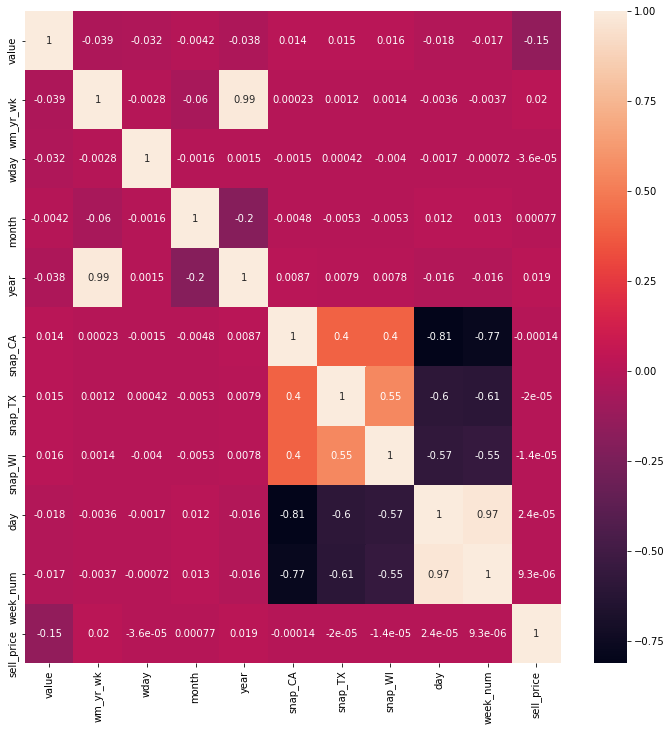

In [15]:
plt.figure(figsize = (12,12))
sn.heatmap(df.corr(), annot=True)

The correlation before feature engineering can be seen here -
* snap has good correlation with day and week num
* value has a little correlation with sell price at the moment

In [16]:
df.dtypes

date            datetime64[ns]
id                    category
value                    int32
wm_yr_wk                 int16
weekday               category
wday                     int16
month                    int16
year                     int16
event_name_1          category
event_type_1          category
event_name_2          category
event_type_2          category
snap_CA                  int16
snap_TX                  int16
snap_WI                  int16
day                       int8
week_num                  int8
store_id              category
item_id               category
sell_price             float16
cat_id                category
state_id              category
dtype: object

In [17]:
df.isnull().sum()

date                   0
id                     0
value                  0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    42341567
event_type_1    42341567
event_name_2    45933474
event_type_2    45933474
snap_CA                0
snap_TX                0
snap_WI                0
day                    0
week_num               0
store_id               0
item_id                0
sell_price             0
cat_id                 0
state_id               0
dtype: int64

we can leave all the null values of the events as it isnt possible for each day of the year to have a event

In [18]:
sales_train_df.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [19]:
calendar_df.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,day,week_num
count,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,15.703084,2.696811
std,150.413499,2.001175,3.459678,1.532487,0.470091,0.470091,0.470091,8.795781,1.268823
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,8.000000,2.000000
50%,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,16.000000,3.000000
75%,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,23.000000,4.000000
max,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,31.000000,5.000000


In [20]:
sell_prices_df.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,NaN
std,1.486100e+02,0.000000e+00
min,1.110100e+04,1.000214e-02
25%,1.124700e+04,2.179688e+00
50%,1.141100e+04,3.470703e+00
75%,1.151700e+04,5.839844e+00
max,1.162100e+04,1.073125e+02


## UNIVARIATE ANALYSIS

In [21]:
#value
temp = df.groupby(["cat_id", "date"])["value"].sum()

In [22]:
x = temp[temp.index.get_level_values("cat_id") == 'FOODS'].values

(array([  5.,   0.,   0.,  60., 284., 595., 521., 281., 147.,  20.]),
 array([1.10000e+01, 3.86460e+03, 7.71820e+03, 1.15718e+04, 1.54254e+04,
        1.92790e+04, 2.31326e+04, 2.69862e+04, 3.08398e+04, 3.46934e+04,
        3.85470e+04]),
 <a list of 10 Patch objects>)

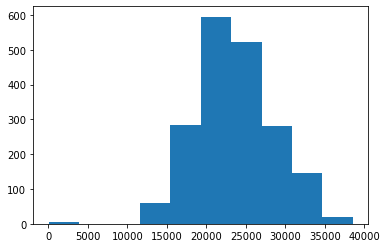

In [23]:
plt.hist(x)

(array([  5.,   1.,  77., 285., 388., 515., 306., 206.,  97.,  33.]),
 array([    0. ,  1388.9,  2777.8,  4166.7,  5555.6,  6944.5,  8333.4,
         9722.3, 11111.2, 12500.1, 13889. ]),
 <a list of 10 Patch objects>)

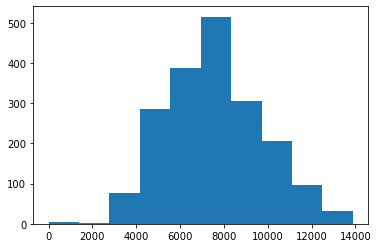

In [24]:
x = temp[temp.index.get_level_values("cat_id") == 'HOUSEHOLD'].values
plt.hist(x)

In [25]:
gc.collect()

20

(array([  5.,   1.,   4.,  75., 378., 535., 517., 254., 111.,  33.]),
 array([   0.,  536., 1072., 1608., 2144., 2680., 3216., 3752., 4288.,
        4824., 5360.]),
 <a list of 10 Patch objects>)

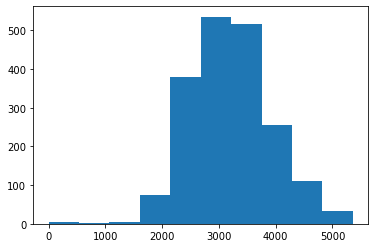

In [26]:
x = temp[temp.index.get_level_values("cat_id") == 'HOBBIES'].values
plt.hist(x)

In [27]:
del x, temp
gc.collect()

20

### so  as we can note few points in this section
* Food has the highest frequency among the others 
* Food and Hobbies are highly left skewed 
* Household is little left skewed

In [28]:
# ALTERNATE PROCEDURE Of DOING THIS WILL BE SHOWN HERE after some time

#### Next is EVENTS UNIVARIATE ANALYSIS

In [29]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day,week_num
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,29,5
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,30,5
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,31,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2,1


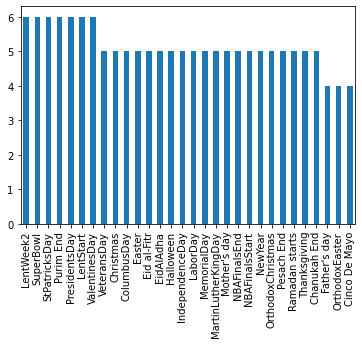

In [30]:
calendar_df['event_name_1'].value_counts().plot.bar()

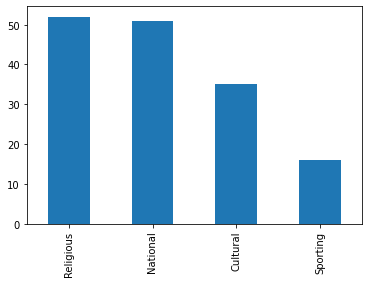

In [31]:
calendar_df['event_type_1'].value_counts().plot.bar()

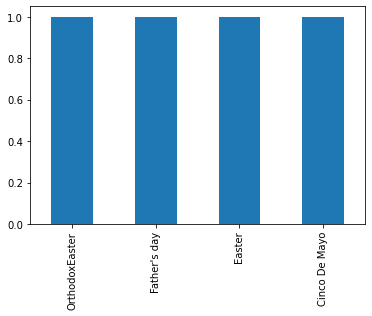

In [32]:
calendar_df['event_name_2'].value_counts().plot.bar()

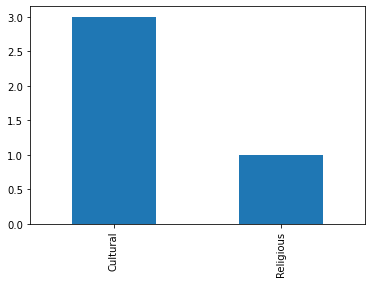

In [33]:
calendar_df['event_type_2'].value_counts().plot.bar()

#### So as we can see in event type one in event type one -
* The highest frequncy is of 7 events - lentweek2 , superbowl, StPatricksDay, Purim End, President start, LentStart, Valentines day
* The highest frequency is of Relegious events in whole

#### And in event type 2 - 

* All events have same frequency
* although as whole cultral events can be seen more

### Lets move on to SNAP analyis 

In [34]:
calendar_df["snap_CA"].value_counts()

0    1283
1     630
Name: snap_CA, dtype: int64

In [35]:
calendar_df["snap_TX"].value_counts()

0    1283
1     630
Name: snap_TX, dtype: int64

In [36]:
calendar_df["snap_WI"].value_counts()

0    1283
1     630
Name: snap_WI, dtype: int64

#### There are equal no. of times when Snap has happened in each of the states

Lets check this in df 

In [37]:
df["snap_CA"].value_counts()

0    30913873
1    15114084
Name: snap_CA, dtype: int64

In [38]:
df["snap_TX"].value_counts()

0    30894279
1    15133678
Name: snap_TX, dtype: int64

In [39]:
df["snap_WI"].value_counts()

0    30892459
1    15135498
Name: snap_WI, dtype: int64

#### Therefore having same ratio in snap indicate that our data has been correctly been fitted

### CAT_ID

In [40]:
df["cat_id"].value_counts()

FOODS        21395953
HOUSEHOLD    15989319
HOBBIES       8642685
Name: cat_id, dtype: int64

In [41]:
sell_prices_df["cat_id"].value_counts()

FOODS        3181789
HOUSEHOLD    2375427
HOBBIES      1283905
Name: cat_id, dtype: int64

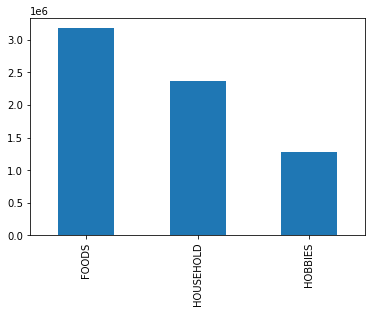

In [42]:
sell_prices_df["cat_id"].value_counts().plot.bar()

#### We have 
* 3181789 products in foods category
* 2375427 products in HouseHold category
* 1283905 products in Hobbies category

to conclude this we can say highest no. of products have been registered in Foods category while lowest in Hobbies category

### STATE_ID

In [43]:
sell_prices_df["state_id"].value_counts()

CA    2708822
TX    2092122
WI    2040177
Name: state_id, dtype: int64

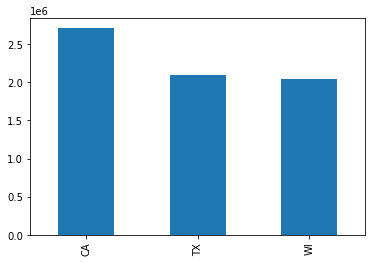

In [44]:
sell_prices_df["state_id"].value_counts().plot.bar()

* Canada has highest no. of products registered
* Texas and West indies have apporximately the same no. of products registered if round of by 10,000

### STORE_ID

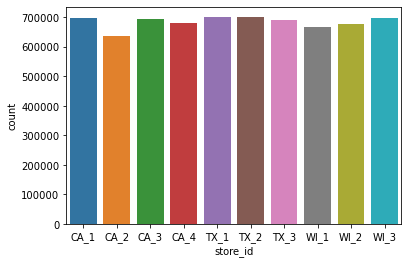

In [45]:
sn.countplot(sell_prices_df.store_id)

In [46]:
sell_prices_df.store_id.value_counts()

TX_2    701214
TX_1    699796
CA_1    698412
WI_3    696094
CA_3    693990
TX_3    691112
CA_4    679025
WI_2    678171
WI_1    665912
CA_2    637395
Name: store_id, dtype: int64

In this we got to know 
* TX_2 has highest no. of products followed by TX_1
* At third comes CA_1
* last position is attained by CA_2

# BIVARIATE ANALYSIS

In [47]:
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_CA,snap_TX,snap_WI,day,week_num,store_id,item_id,sell_price,cat_id,state_id
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,NaN,NaN,...,0,0,0,29,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,NaN,NaN,...,0,0,0,30,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,NaN,NaN,...,0,0,0,31,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,NaN,NaN,...,1,1,0,1,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,NaN,NaN,...,1,0,1,2,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA


1. We have to find relations of these with respect to the column value.
2. Inter category relations

### TIME SERIES ANALYSIS W.R.T cat_id

#### first as whole 

In [48]:
temp  = df.groupby(["cat_id", "date"])["value"].sum()

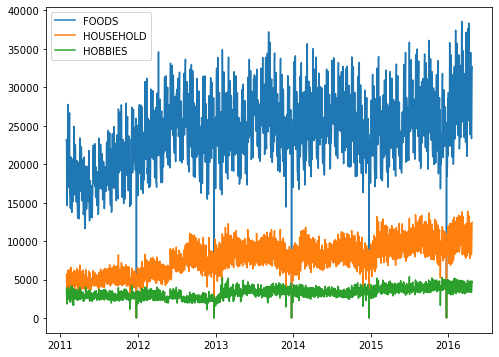

In [49]:
plt.figure(figsize = (8,6))
plt.plot(temp[temp.index.get_level_values('cat_id') == "FOODS"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "FOODS"].values, label ="FOODS")
plt.plot(temp[temp.index.get_level_values('cat_id') == "HOUSEHOLD"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "HOUSEHOLD"].values, label ="HOUSEHOLD")
plt.plot(temp[temp.index.get_level_values('cat_id') == "HOBBIES"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "HOBBIES"].values, label ="HOBBIES")
plt.legend()
plt.show()

3085

#### EVENT CLEANING UP SEQUENCE

In [59]:
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_CA,snap_TX,snap_WI,day,week_num,store_id,item_id,sell_price,cat_id,state_id
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,NaN,NaN,...,0,0,0,29,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,NaN,NaN,...,0,0,0,30,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,NaN,NaN,...,0,0,0,31,5,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
3,2011-02-01,HOBBIES_1_008_CA_1_validation,0,11101,Tuesday,4,2,2011,NaN,NaN,...,1,1,0,1,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA
4,2011-02-02,HOBBIES_1_008_CA_1_validation,0,11101,Wednesday,5,2,2011,NaN,NaN,...,1,0,1,2,1,CA_1,HOBBIES_1_008,0.459961,HOBBIES,CA


In [55]:
#So lets analyze events first like how do they affect the data 
#first we will take event_type_1 in considerations
event_call = df.groupby(["event_name_1", "date"])["value"].sum()

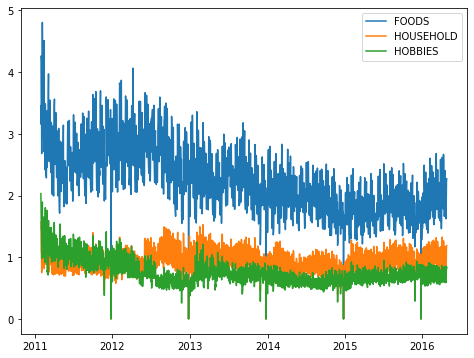

In [53]:
plt.figure(figsize = (8,6))
plt.plot(temp[temp.index.get_level_values('cat_id') == "FOODS"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "FOODS"].values, label ="FOODS")
plt.plot(temp[temp.index.get_level_values('cat_id') == "HOUSEHOLD"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "HOUSEHOLD"].values, label ="HOUSEHOLD")
plt.plot(temp[temp.index.get_level_values('cat_id') == "HOBBIES"].index.get_level_values("date"), temp[temp.index.get_level_values('cat_id') == "HOBBIES"].values, label ="HOBBIES")
plt.legend()
plt.show()

In [65]:
pd.get_dummies(calendar_df, columns=["event_name_1"]).head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_type_1,event_name_2,event_type_2,...,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
